add biogramy_info.csv to runtime

In [ ]:
!pip install -U spacy
!python -m spacy info

     |████████████████████████████████| 6.0 MB 5.2 MB/s 
     |████████████████████████████████| 653 kB 46.8 MB/s 
     |████████████████████████████████| 457 kB 48.9 MB/s 
     |████████████████████████████████| 10.1 MB 54.1 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 181 kB 44.5 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.

In [ ]:
!python -m spacy download pl_core_news_sm


     |████████████████████████████████| 58.6 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load("pl_core_news_sm")

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
candidate_sentences = pd.read_csv("biogramy_info.csv")
candidate_sentences.shape

(26416, 1)

In [ ]:
candidate_sentences[:5]

sentence
0                                                                Łukasz Abgarowicz , ur. 18 X 1949 w Bydgoszczy. Absolwent Szkoły Głównej Gospodarstwa Wiejskiego w Warszawie, Wydz. Zootechniczny (1972).
1                                                                                    W III 1968 współorganizator wiecu i strajku na Szkoła Główna Gospodarstwa Wiejskiego w Warszawie (Akademia Rolnicza).
2                                                                                                               1972–1988 aspirant/trener koni wyścigowych Państwowych Torów Wyścigów Konnych w Warszawie.
3                      Od IX 1980 w „S”; przew. koła; w VI 1981 delegat na I WZD Regionu Mazowsze, członek ZR, IX/X delegat na I Komisja ZakładowaD; przew. Sekcji Pracowników Rolnictwa Regionu Mazowsze.
4  Po 13 XII 1981 współpracownik podziemnego Radia „S” w Warszawie, współorganizator łączności międzyregionalnej podziemnych struktur „S”. Wielokrotnie zatrzymywany i przesłuchiwany. 1988–1989 człone...

In [ ]:
!pip install dateparser
import dateparser


test = """Abramczyk Piotr - Biogramy -  Piotr Abramczyk, ur. 11 IV 1966 w Szczytnie. Ukończył ZSZ przy Gdańskiej Stoczni Remontowej (1984)."""
oth = """Łukasz Abgarowicz , ur. 18 X 1949 w Bydgoszczy. Absolwent Szkoły Głównej Gospodarstwa Wiejskiego w Warszawie, Wydz. Zootechniczny (1972)."""
nxt = """"Bochwic Teresa Maria - Biogramy -  Teresa Maria Bochwic, ur. 11 IX 1947 r. w Warszawie. Absolwentka Uniwersytetu Warszawskiego, kierunek filozofia (1971), doktorat w zakresie pedagogiki w Akademii Pedagogiki Specjalnej im. Marii Grzegorzewskiej w Warszawie (2007)."""

def extract_stuff_from_desc(text, dt, city):
  stuff = nlp(text)
  dates = dict()
  orgs = dict()
  places = dict()
  grad_phrases = {'ukończył', 'ukończyła', 'absolwent', 'absolwentka'}

  for ent in stuff.ents:
    print(ent.text, ent.label_)
    if ent.label_ == 'date':
      dates[ent.start_char] = dateparser.parse(ent.text)
    elif ent.label_ == 'orgName':
      orgs[ent.start_char] = ent.text
    elif ent.label_ == 'placeName':
      places[ent.start_char] = ent.text

  name = None
  bornFlag = False
  college = None
  collegeFlag = False
  birthPlaceFlag = False
  for i, token in enumerate(stuff):
    if token.text == 'ur':
      bornFlag = True
    elif token.text == 'w':
      birthPlaceFlag = True
    elif not city and birthPlaceFlag and token.idx in places:
      city = places[token.idx]
      birthPlaceFlag = False
    elif token.text.lower() in grad_phrases:
      collegeFlag = True
    elif collegeFlag and token.idx in orgs:
      college = orgs[token.idx]
      collegeFlag = False
    elif not dt and bornFlag and token.idx in dates:
      dt = dates[token.idx]
      bornFlag = False
  return dt, college, city

extract_stuff_from_desc(nxt, 'asdf', 'asdf')

Bochwic placeName
Teresa Maria - Biogramy persName
Teresa Maria Bochwic persName
11 IX 1947 r. date
Warszawie placeName
Uniwersytetu Warszawskiego orgName
Akademii Pedagogiki Specjalnej im. orgName
2007 date


('asdf', 'Uniwersytetu Warszawskiego', 'asdf')

In [ ]:
doc = candidate_sentences['sentence'][0]
# sent = list(doc)[0]
# doc = nlp(sent)
# print(doc)
doc = nlp(doc)

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Łukasz Abgarowicz 0 17 persName
18 X 1949 24 33 date
Bydgoszczy 36 46 placeName
Szkoły Głównej Gospodarstwa Wiejskiego w Warszawie 58 108 orgName
Wydz 110 114 placeName
1972 131 135 date


In [ ]:
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})


In [ ]:
for tok in doc:
  print(tok.text, "...", tok.dep_)

Łukasz ... ROOT
Abgarowicz ... flat
, ... punct
ur ... nmod
. ... punct
18 ... amod
X ... amod:flat
1949 ... amod
w ... case
Bydgoszczy ... nmod
. ... punct
Absolwent ... ROOT
Szkoły ... nmod
Głównej ... amod:flat
Gospodarstwa ... nmod:flat
Wiejskiego ... amod:flat
w ... case
Warszawie ... nmod
, ... punct
Wydz ... appos
. ... punct
Zootechniczny ... ROOT
( ... punct
1972 ... amod
) ... punct
. ... punct


In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
get_entities("muszę się wysrać")

['', '']

In [ ]:
get_entities(doc)

['', '']

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 20027/20027 [07:32<00:00, 44.23it/s]


In [ ]:
entity_pairs[10:20]

[['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', 'IX  Komisji'],
 ['TKomisja', 'Odwoławczą  ds'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', '']]

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

  0%|          | 0/20027 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
pd.Series(relations).value_counts()[:50]

Polski            690
Od                648
emeryturze        585
tamże             497
członek           404
Warszawie         273
do                256
S                 223
Gdańsku           185
oraz              185
Solidarności      168
Zasługi           160
i                 143
Kultury           140
w                 133
ZakładowaD.       130
Wolności          130
Szczecinie        128
I                 122
Krakowie          120
Solidarność       118
rencie            117
na                117
Lublinie          108
PZPR              100
Poznaniu           93
Prawa              87
prezes             86
zawodowy           81
uczestnik          77
Rzeszowie          73
ramach             70
Administracji      70
Solidarmość        69
Warszawskiego      62
Polskiej           60
działacz           60
Olsztynie          59
przesłuchiwany     59
Gdyni              56
we                 53
pracownik          53
odznaką            52
Zakładowa          49
Kaliszu            48
Białej    

In [ ]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [ ]:

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

KeyboardInterrupt: ignored

<Figure size 864x864 with 0 Axes>

In [ ]:
print(len(relations))
rel = pd.Series(relations).sample(1)
rel = list(rel)[0]
rel

20027


'Mechanicznego'

In [ ]:
src = list(kg_df['source'].sample(1))[0]
src

'1987 Spraw Wewnętrznych w'

In [ ]:
kg_df[kg_df['source']==src]

source                          target        edge
9488   1987 Spraw Wewnętrznych w                             SOS         III
10029  1987 Spraw Wewnętrznych w  1987 rozpracowywana przez Wydz      Kaseta
12827  1987 Spraw Wewnętrznych w                        KE krypt  Defraudant
14303  1987 Spraw Wewnętrznych w  1987 rozpracowywana przez Wydz       Anita

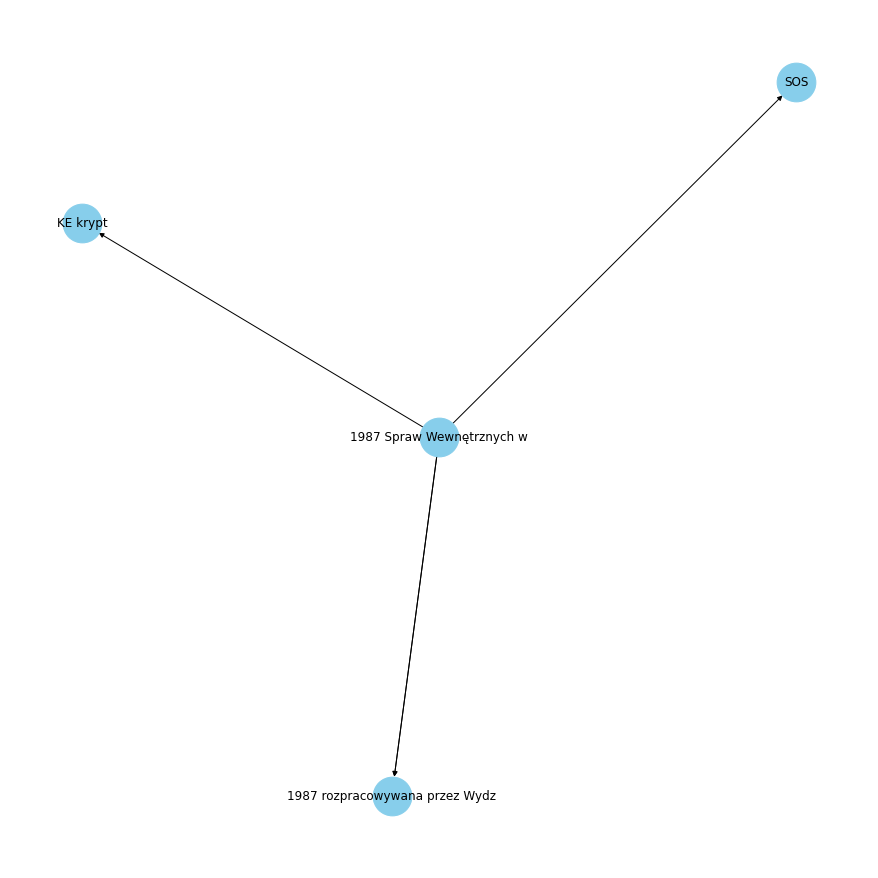

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['source']==src], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

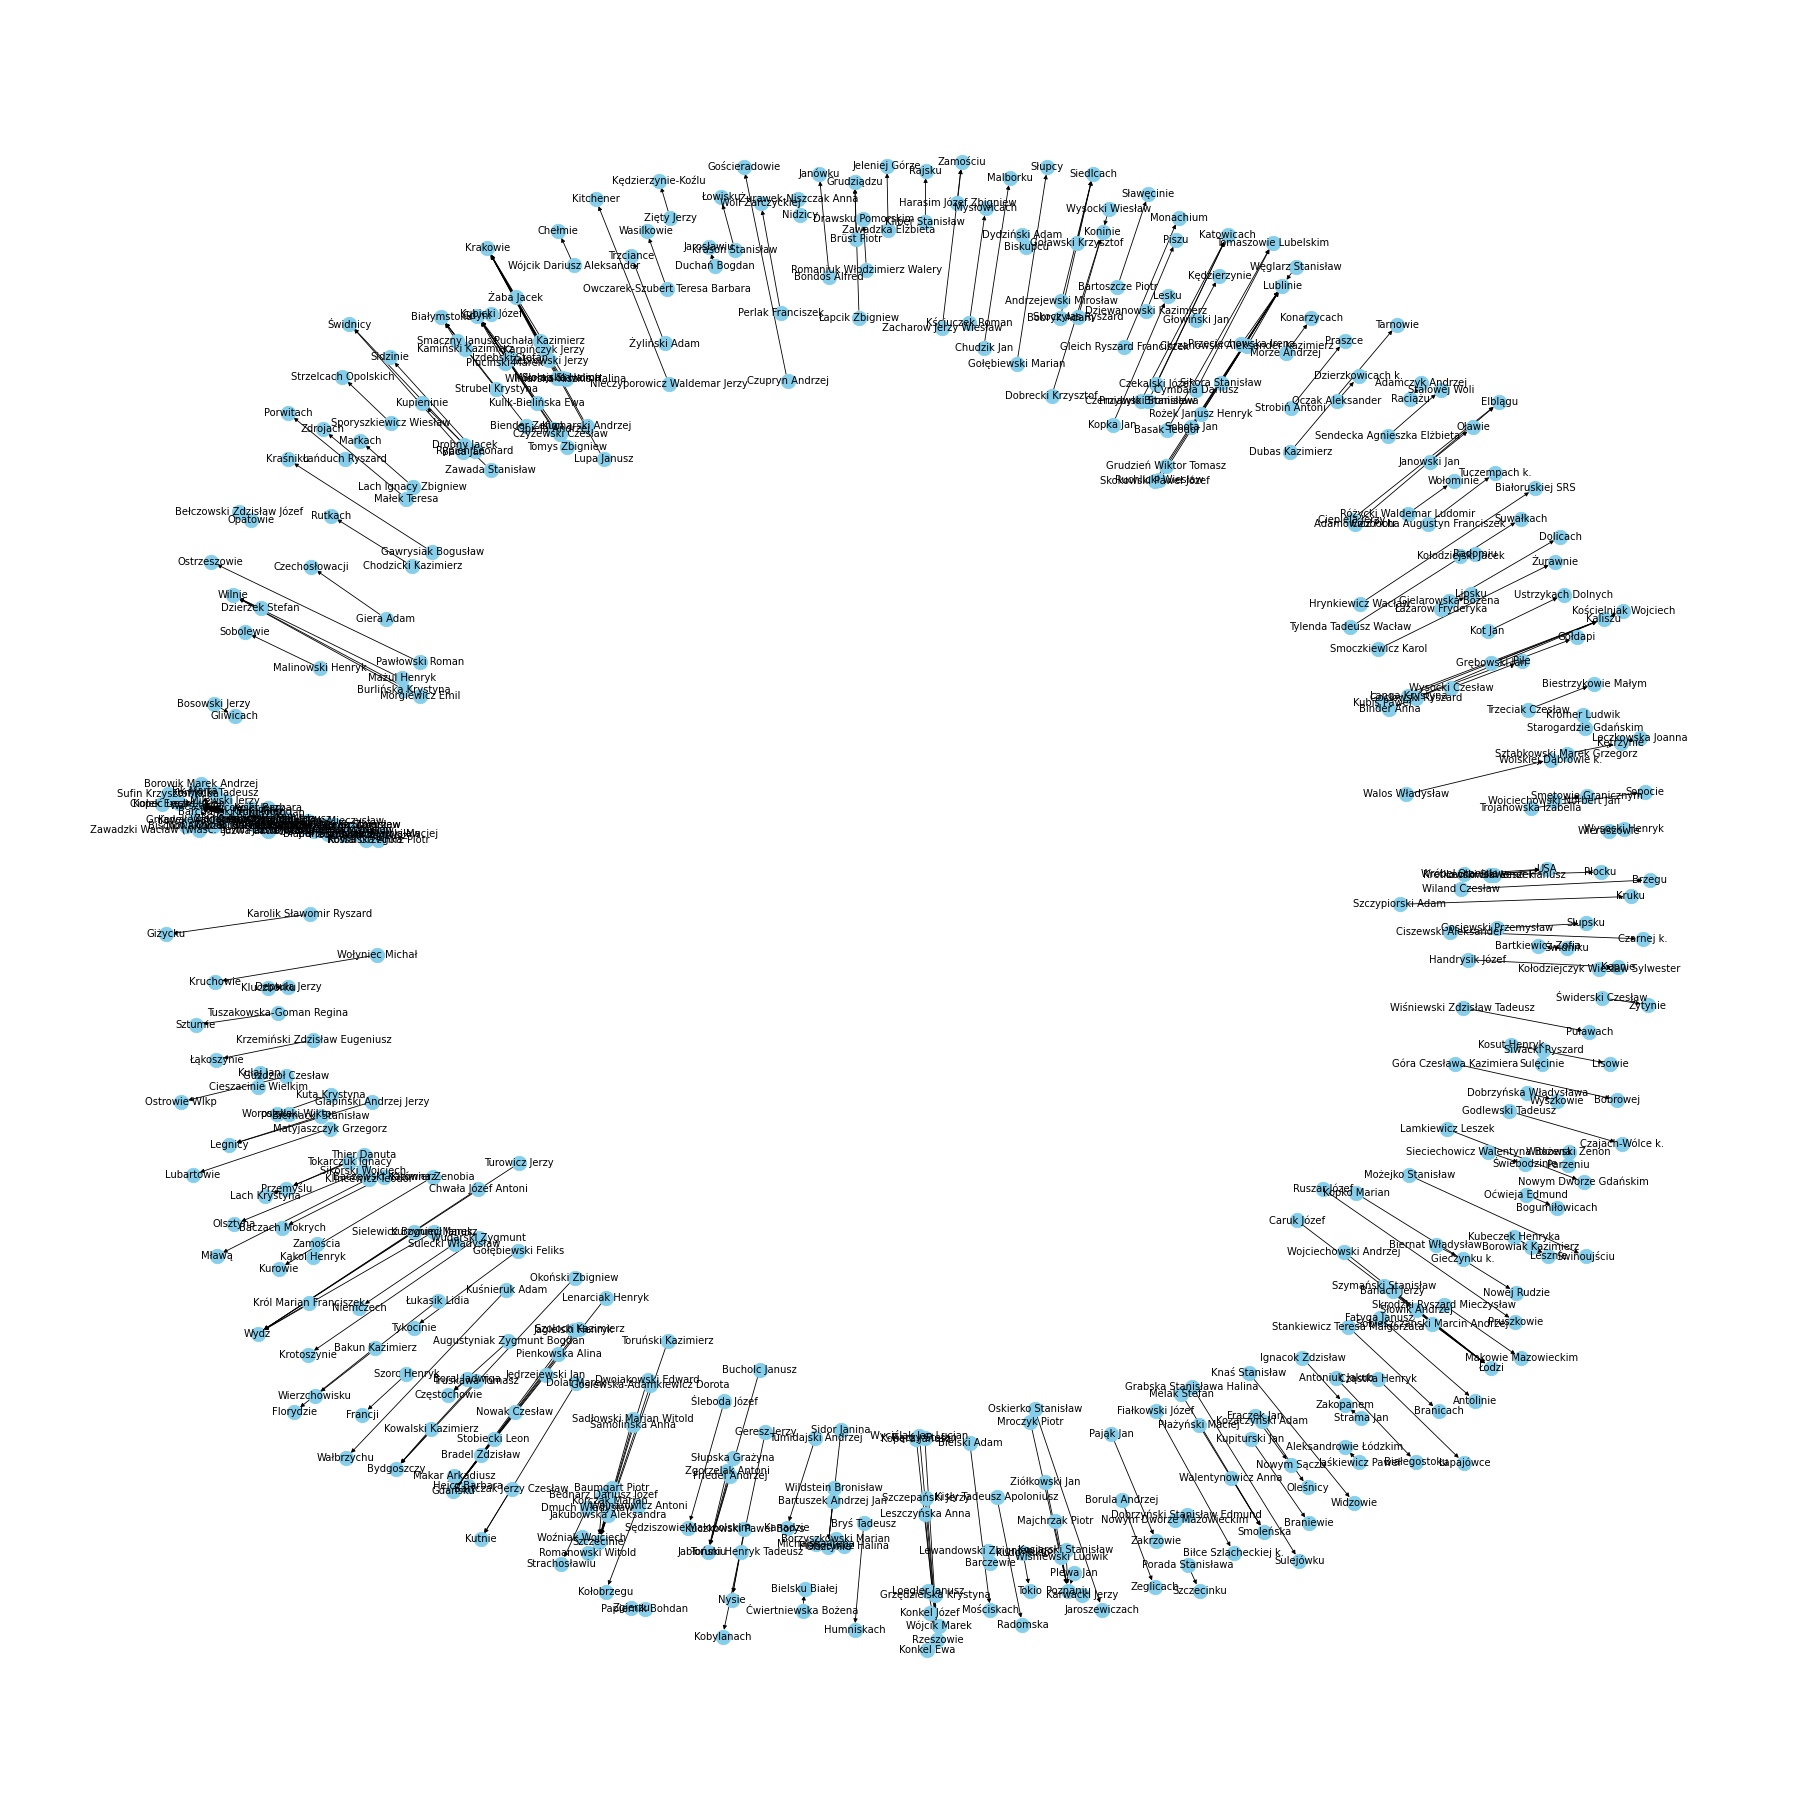

In [ ]:
# read the parsed bio info and graph it
from matplotlib.pyplot import figure
import networkx as nx

G = nx.Graph()
df = pd.read_json('biogramy_info_new.json')
# show graph of people who did not go to colleges' birth cities
df = df[df['college'] == 'none']
df = df[df['birth_place'] != 'none']
df1 = df[['name', 'birth_place']]

names = df1['name'].tolist()
birth_place = df1['birth_place'].tolist()
relations = ['birthplace' for elem in names]

name_to_birth_place = pd.DataFrame({'source':names, 'target':birth_place, 'edge':relations})

G=nx.from_pandas_edgelist(name_to_birth_place, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(1, figsize=(30,30), dpi=60)

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

['Warszawie', 'Wydz', 'Gdańsku', 'Lublinie', 'Poznaniu', 'Krakowie', 'Szczecinie', 'Gdyni', 'Łodzi', 'Bielsku-Białej', 'Olsztynie', 'Toruniu', 'Rzeszowie', 'Kaliszu', 'Radomiu', 'Katowicach', 'Sopocie', 'polska', 'Białymstoku', 'Stalowej Woli', 'Bydgoszczy', 'Gliwicach', 'Przemyślu', 'Nowym Sączu', 'Wałbrzychu', 'Wilnie', 'Opolu', 'Koninie', 'Siedlcach', 'Częstochowie', 'Puławach', 'Kielcach', 'Pionkach', 'Ostrowie Wlkp', 'Jarosławiu', 'Ostrowie Wielkopolskim', 'Płocku', 'Łomży', 'Suwałkach', 'Paryżu', 'USA', 'Pile', 'Tczewie', 'Krośnie', 'Chełmie', 'Ełku', 'Nysie', 'Łańcucie', 'Białogardzie', 'Grudziądzu', 'Jarocinie', 'Elblągu', 'Tarnowie', 'Kutnie', 'Głogowie', 'Koszalinie', 'Otwocku', 'Zielonej Górze', 'Zamościu', 'Słupsku', 'Milanówku', 'Legnicy', 'Malborku', 'Jaworze', 'Jeleniej Górze', 'Nowej Soli', 'Starogardzie Gdańskim', 'Sandomierzu', 'Kępnie', 'Żarach', 'Chorzowie', 'Smoleńska', 'Pruszkowie', 'Świdniku', 'Dąbrowie Górniczej', 'Ostrowcu Świętokrzyskim', 'Dzierżoniowie', 'Kęt

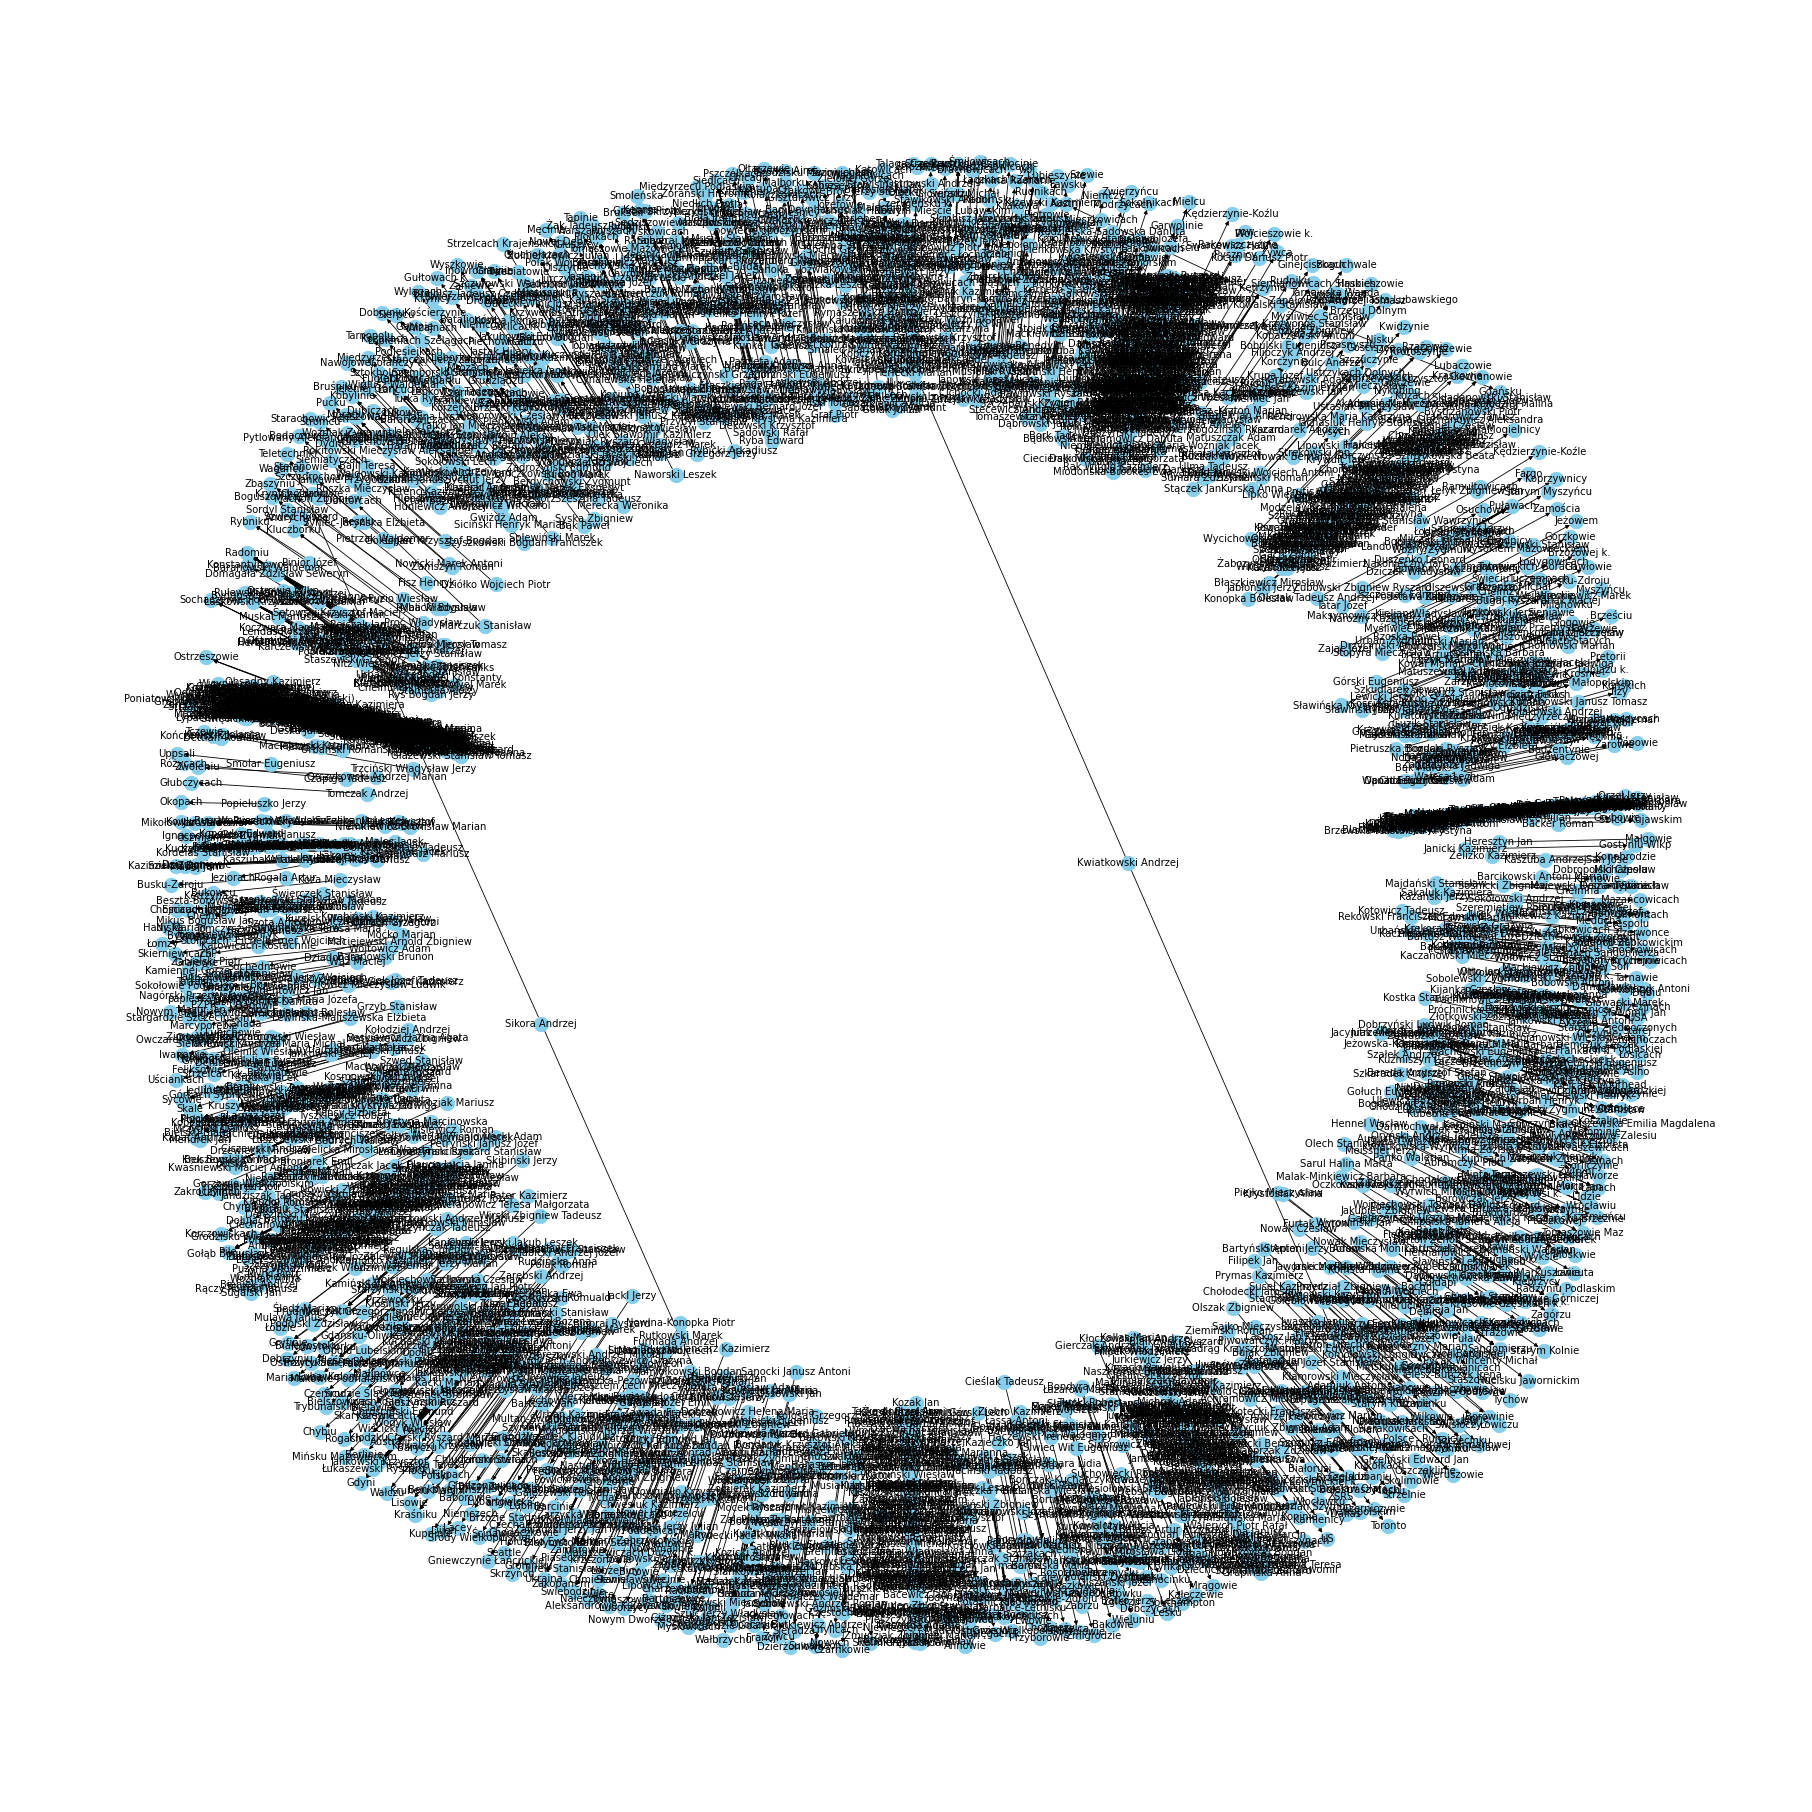

In [ ]:
# read the parsed bio info and graph it
from matplotlib.pyplot import figure
import networkx as nx
from collections import Counter

G = nx.Graph()
df = pd.read_json('biogramy_info_new.json')
# show graph of people who went to college by birthplace
df = df[df['college'] != 'none']
df_all_bdays = df[df['bday'] != 'none']
all_bdays = df_all_bdays['bday'].tolist()
colleges = df['college'].tolist()
df = df[df['birth_place'] != 'none']
df1 = df[['name', 'birth_place']]

names = df1['name'].tolist()
birth_place = df1['birth_place'].tolist()
relations = ['birthplace' for elem in names]

counts = dict()
for item in birth_place:
  counts[item] = counts.get(item, 0) + 1

# freq of birthplaces
print(sorted(counts, key=counts.get, reverse=True))

college_counts = dict()
for item in colleges:
  college_counts[item] = college_counts.get(item, 0) + 1

# freq of college counts
for key in college_counts:
  if 'Zasadniczą Szkołę Zawodową' in key:
    college_counts['ZSZ'] += college_counts[key]

print(sorted(college_counts, key=college_counts.get, reverse=True))

# freq of years
print(all_bdays[0])
years = [int(bday.split('-')[0]) for bday in all_bdays if int(bday.split('-')[0]) < 2000]
years.sort()
print(years)
print(sum(years) / len(years))



name_to_birth_place = pd.DataFrame({'source':names, 'target':birth_place, 'edge':relations})

G=nx.from_pandas_edgelist(name_to_birth_place, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(1, figsize=(30,30), dpi=60)

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
# read the parsed bio info and graph it
from matplotlib.pyplot import figure
import networkx as nx
from collections import Counter

G = nx.Graph()
df = pd.read_json('biogramy_info_new.json')
# show graph of people who went to college by birthplace
df = df[df['college'] != 'none']
df_all_bdays = df[df['bday'] != 'none']
all_bdays = df_all_bdays['bday'].tolist()
colleges = df['college'].tolist()
df = df[df['birth_place'] != 'none']
df1 = df[['name', 'birth_place']]

all_org_words = df['related_orgs'].tolist()

org_counts = Counter()

for arr in all_org_words:
  tmp = Counter()
  for item in arr:
    tmp[item] = tmp.get(item, 0) + 1
  org_counts += tmp

print(sorted(org_counts, key=org_counts.get, reverse=True))


['„S”', 'Wydz', 'Komitetu Założycielskiego', 'SOS', 'Solidarności', 'AŚ', 'KS', 'KE krypt', 'SB', 'Uniwersytetu Warszawskiego', 'MO', 'KO „S”', 'Zasłużony Działacz Kultury', 'ZK', 'UW', 'KZ „S”', '„Tygodnik Mazowsze”', 'MKZ', 'kolegium ds.', 'WZD', 'KIK', 'KW MO', 'MKS', 'Stoczni Gdańskiej im.', 'Kawalerskim Orderu Odrodzenia', 'KW MO/WUSW', 'Uniwersytetu', 'KPN', 'ZSZ', 'AWS', 'KZ', 'KZD', 'KK', 'NZS', 'KOR', 'III KW MO', 'Sejmu PRL', '„S” RI', 'z o.o.', 'Duszpasterstwa Ludzi Pracy', 'ROPCiO', 'ZHP', 'PZPR', 'Radia „S”', 'KOWzP', '„Solidarność Walcząca”', 'Uniwersytetu Latającego', '„Robotnik”', 'Katolickiego Uniwersytetu Lubelskiego', 'PiS', 'LO', 'Komisji Wydziałowej', 'solidarnościowego', 'TKZ', 'Stoczni Gdańskiej', 'WSI', 'KE krypt.', 'RP', 'Politechniki Gdańskiej', 'Uniwersytetu im.', 'KO', 'archidiecezji warszawskiej', 'Ogólnopolską Pielgrzymkę Ludzi Pracy', 'Komitetu Założycielskiego „S”', 'NOWa', 'Stoczni Szczecińskiej im.', 'Rady Państwa', 'Rady Pracowniczej', 'RKW', 'Uniwers